In [52]:
# Downscaling temperature in Borneo

# Load Packages
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [53]:
# Step 1: Calculate low resolution temperature at sea level

# Load the air temperature in low resolution (this data set has the extent that covers the SAFE project)
lowres_temperature = xr.open_dataset('lowres_temperature.nc')
lowres_temperature

<xarray.Dataset>
Dimensions:    (longitude: 20, latitude: 20, time: 240)
Coordinates:
  * longitude  (longitude) float32 116.0 116.1 116.2 116.3 ... 117.7 117.8 117.9
  * latitude   (latitude) float32 5.92 5.82 5.72 5.62 ... 4.32 4.22 4.12 4.02
  * time       (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-29 11:40:13 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [54]:
# Load geopotential in low resolution
geopotential_in = xr.open_dataset('lowres_geopotential.nc')
geopotential_in

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 1801, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 2013-08-09T12:00:00
Data variables:
    z          (time, latitude, longitude) float64 ...
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

In [55]:
# clip geopotential to same extent as temperature
min_lon = 116.02
min_lat = 4.02
max_lon = 117.92
max_lat = 5.92

geopotential = geopotential_in.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
geopotential

<xarray.Dataset>
Dimensions:    (longitude: 19, latitude: 19, time: 1)
Coordinates:
  * longitude  (longitude) float32 116.1 116.2 116.3 116.4 ... 117.7 117.8 117.9
  * latitude   (latitude) float32 5.9 5.8 5.7 5.6 5.5 ... 4.5 4.4 4.3 4.2 4.1
  * time       (time) datetime64[ns] 2013-08-09T12:00:00
Data variables:
    z          (time, latitude, longitude) float64 ...
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

In [56]:
# Interpolate geopotential data onto a lowres_temperature latitude and longitude grid
geopotential= geopotential.interp(
    latitude=lowres_temperature['latitude'],
    longitude=lowres_temperature['longitude'],
    method='linear'  # Select the interpolation method, 'linear' is one of the commonly used interpolation methods
)
geopotential

/Users/yangcan/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/yangcan/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/yangcan/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/yangcan/opt/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.ge

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 20, longitude: 20)
Coordinates:
  * time       (time) datetime64[ns] 2013-08-09T12:00:00
  * latitude   (latitude) float32 5.92 5.82 5.72 5.62 ... 4.32 4.22 4.12 4.02
  * longitude  (longitude) float32 116.0 116.1 116.2 116.3 ... 117.7 117.8 117.9
Data variables:
    z          (time, latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

In [57]:
# Convert geopotential to altitude
gravity = 9.81
earth_radius = 6371000 # in meters
altitude = (geopotential * earth_radius) / (gravity * earth_radius - geopotential)
altitude

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 20, longitude: 20)
Coordinates:
  * time       (time) datetime64[ns] 2013-08-09T12:00:00
  * latitude   (latitude) float32 5.92 5.82 5.72 5.62 ... 4.32 4.22 4.12 4.02
  * longitude  (longitude) float32 116.0 116.1 116.2 116.3 ... 117.7 117.8 117.9
Data variables:
    z          (time, latitude, longitude) float64 nan nan nan ... nan nan nan

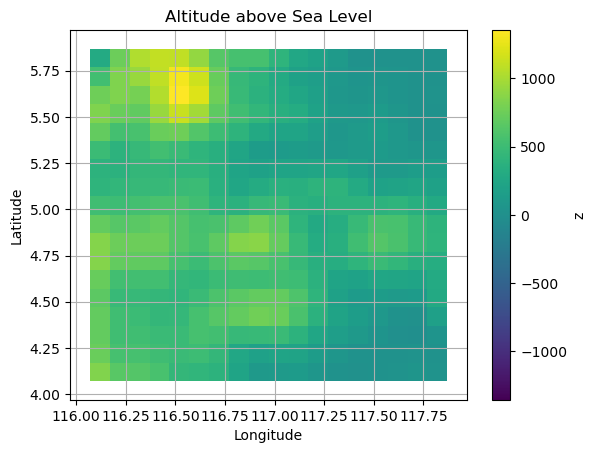

In [58]:
# 使用 xarray 的 plot 方法绘图，然后自定义 matplotlib 的一些设置
altitude['z'].plot(cmap='viridis')

plt.title('Altitude above Sea Level')  # 添加标题
plt.xlabel('Longitude')  # 添加x轴标签
plt.ylabel('Latitude')  # 添加y轴标签
plt.grid(True)  # 显示网格

plt.show()

In [59]:
# Adjust low resolution temperature to mean sea level
# Specify the lapse rate (-0.006 K m^-1)
lapse_rate = -0.006

lowres_temperature_sealevel = lowres_temperature['t2m'].values - (altitude['z'].values * lapse_rate)
lowres_temperature_sealevel = xr.DataArray(
    lowres_temperature_sealevel,
    dims=['time','longitude','latitude'],
    coords={
        'time': lowres_temperature.time,
        'longitude': lowres_temperature.longitude,
        'latitude': lowres_temperature.latitude,
    }
)
lowres_temperature_sealevel.shape

(240, 20, 20)

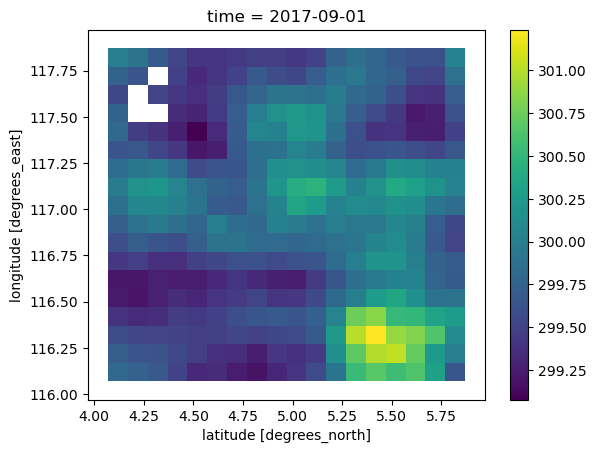

In [60]:
lowres_temperature_sealevel.isel(time=200).plot(cmap='viridis')

In [61]:
# Step 2: to interpolate temperature data to 100 m resolution using nearest neighbor
# Specify the original grid coordinates

lon = lowres_temperature['longitude'].values
lat = lowres_temperature['latitude'].values

# Define the desired grid resolution (1 km)
new_resolution = 0.1  # in km

# Convert the resolution to degrees
degree_per_km = 1 / 111.32  # approximate value for latitude
new_resolution_deg = new_resolution * degree_per_km
new_resolution_deg

0.000898311174991017

In [62]:
# Create a new grid of longitude and latitude coordinates with higher resolution

new_lon = np.arange(lon.min(), lon.max(), new_resolution_deg)
new_lat = np.arange(lat.min(), lat.max() , new_resolution_deg)

# Create a meshgrid of the new longitude and latitude coordinates
new_lat_mesh, new_lon_mesh  = np.meshgrid(new_lat,new_lon)

In [63]:
# Create an empty array to store the interpolated temperature values
interpolated_temperature = np.empty((len(lowres_temperature['time']), len(new_lat), len(new_lon)))
interpolated_temperature.shape

(240, 2116, 2116)

In [64]:
lat_mesh, lon_mesh  = np.meshgrid(lat,lon)

In [65]:
print(f"Original lon range: {lon.min()} to {lon.max()}")
print(f"Original lat range: {lat.min()} to {lat.max()}")
print(f"New lon range: {new_lon.min()} to {new_lon.max()}")
print(f"New lat range: {new_lat.min()} to {new_lat.max()}")

Original lon range: 116.0199966430664 to 117.91999816894531
Original lat range: 4.019999980926514 to 5.920000076293945
New lon range: 116.0199966430664 to 117.91992477817602
New lat range: 4.019999980926514 to 5.919928116032375


In [66]:
original_points = np.array([lon_mesh.ravel(), lat_mesh.ravel()]).T  
target_points = np.array([new_lon_mesh.ravel(), new_lat_mesh.ravel()[::-1]]).T

In [68]:
# Interpolate temperature values for each time step
for i in range(len(lowres_temperature['time'])):
    temperature = lowres_temperature_sealevel.isel(time=i).values.ravel()
    global_mean = np.nanmean(temperature)
    temperature_filled = np.where(np.isnan(temperature), global_mean, temperature)
    temperature_flat = temperature_filled.ravel()
    # Fill NaN with global mean
    interpolated_values_flat = griddata(original_points, temperature_flat, target_points, method='nearest')
    
    # Storing the result
    interpolated_temperature[i, :, :] = interpolated_values_flat.reshape(new_lat_mesh.shape)
interpolated_temperature

array([[[298.85474449, 298.85474449, 298.85474449, ..., 298.85474449,
         298.85474449, 298.85474449],
        [298.85474449, 298.85474449, 298.85474449, ..., 298.85474449,
         298.85474449, 298.85474449],
        [298.85474449, 298.85474449, 298.85474449, ..., 298.85474449,
         298.85474449, 298.85474449],
        ...,
        [298.85474449, 298.85474449, 298.85474449, ..., 298.85474449,
         298.85474449, 298.85474449],
        [298.85474449, 298.85474449, 298.85474449, ..., 298.85474449,
         298.85474449, 298.85474449],
        [298.85474449, 298.85474449, 298.85474449, ..., 298.85474449,
         298.85474449, 298.85474449]],

       [[298.95466171, 298.95466171, 298.95466171, ..., 298.95466171,
         298.95466171, 298.95466171],
        [298.95466171, 298.95466171, 298.95466171, ..., 298.95466171,
         298.95466171, 298.95466171],
        [298.95466171, 298.95466171, 298.95466171, ..., 298.95466171,
         298.95466171, 298.95466171],
        ...,


In [48]:
# Interpolate temperature values for each time step
#for i,time in enumerate(range(len(lowres_temperature['time']))):
    # Select temperture
#    temperature = lowres_temperature_sealevel.isel(time=time).values
     # Interpolation
#    interpolator = griddata((np.repeat(lon, len(lat)), np.tile(lat, len(lon))), temperature.ravel(), (new_lon, new_lat), method='nearest')
    
    # Storing the result
#    interpolated_temperature[i, :, :] = interpolator
#interpolated_temperature

In [49]:
# Create a new xarray dataset for the interpolated temperature data
highres_sealevel_temperature = xr.Dataset(
    data_vars={'t2m': (['time', 'latitude', 'longitude'], interpolated_temperature)},
    coords={'time': lowres_temperature['time'], 'latitude': new_lat, 'longitude': new_lon}
)
highres_sealevel_temperature

<xarray.Dataset>
Dimensions:    (time: 240, latitude: 212, longitude: 212)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2020-12-01
  * latitude   (latitude) float64 4.02 4.029 4.038 4.047 ... 5.897 5.906 5.915
  * longitude  (longitude) float64 116.0 116.0 116.0 116.0 ... 117.9 117.9 117.9
Data variables:
    t2m        (time, latitude, longitude) float64 298.9 298.9 ... 299.4 299.4

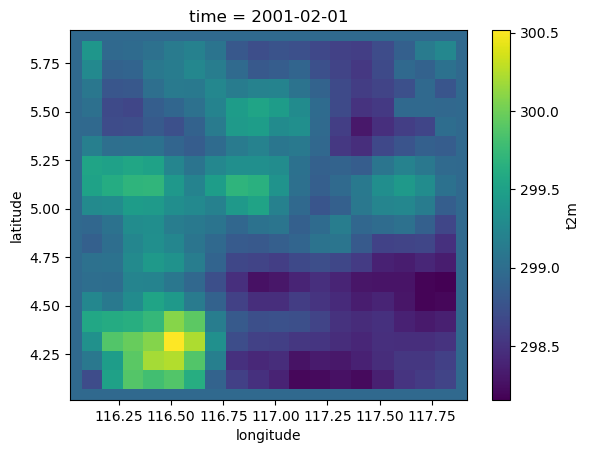

In [50]:
highres_sealevel_temperature['t2m'].isel(time=1).plot()

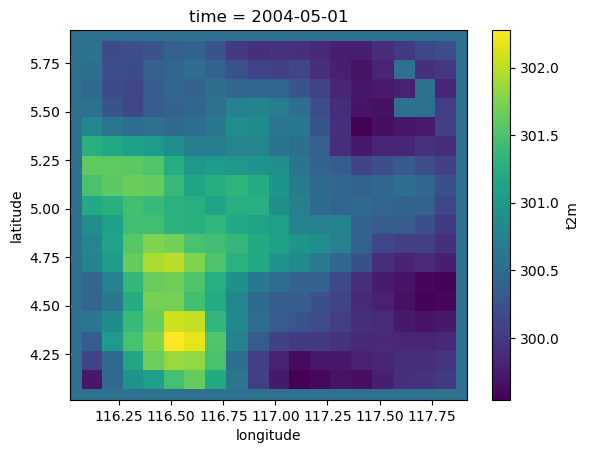

In [51]:
highres_sealevel_temperature['t2m'].isel(time=40).plot()

In [337]:
# 3. Interpolate temperature to high resolution new elevation
# TODO download high resolution elevation data
high_res_elevation_in = xr.open_dataset('Geopotential.nc')
high_res_elevation_in

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 1801, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 2013-08-09T12:00:00
Data variables:
    z          (time, latitude, longitude) float64 ...
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

In [35]:
# Make sure the highres elevation has the same extent and resolution as the highres temperature data
high_res_elevation = 

SyntaxError: invalid syntax (4227520654.py, line 2)

In [36]:
# Calculate temperature as high resolution elevation
highres_temperature = highres_sealevel_temperature + (high_res_elevation * lapse_rate)
highres_temperature

NameError: name 'high_res_elevation' is not defined